# Getting started with Stan

Stan has interfaces for many popular data analysis languages (Python, R, Matlab, Julia, ...).
In this tutorial we use its python interface, called "pystan".

In [1]:
import pystan
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import scipy.stats as ss
%matplotlib inline  



# Coin flipping example
In this example our data consists of the outcomes for N coin flip trials. Our model parameters are `theta` (the probability of observing head), which itself has a beta prior with parameters `a` and `b`.

### Creating a Stan model
We create a Stan model by defining the data variables and their types, model parameters and the distributions for the variables inthe model. 

We defined `a` and `b` in the data section, to be able to experiment with different priors for theta.



In [3]:
coinflip_model = """
data {
    int<lower=0> N;
    int x[N];
    real a;
    real b;
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    theta ~ beta(a, b);
    for (n in 1:N)
        x[n] ~ bernoulli(theta);
}
"""

Next we load and compile the model. Alternatively, we could have written the stan code in a .stan file and passed its address to StanModel "file" argument

In [4]:
sm = pystan.StanModel(model_code=coinflip_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6452044846eaac29bc757135c5f37145 NOW.
/usr/local/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/sd/9d1mbpj50nb11rq4997s9b4r0000gn/T/tmpny7fy7ev/stanfit4anon_model_6452044846eaac29bc757135c5f37145_7265371949366260887.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Experiment one:
Use beta(1, 1) as prior

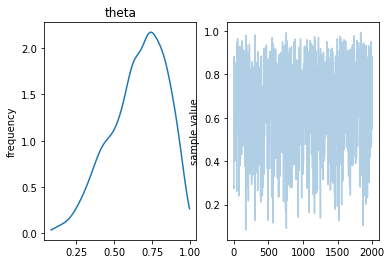

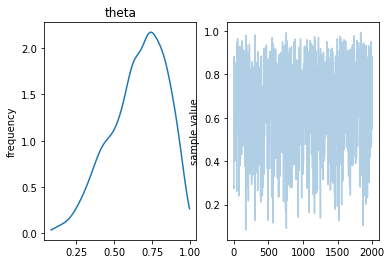

In [5]:
flip_data = {'N':4,
             'x':[1,0,1,1],
             'a':1.0,
             'b':1.0}
fit = sm.sampling(data=flip_data, iter=1000, chains=4)
fit.plot()

### Experiment two:
Use beta(1, 1) as prior, and have all trial outcomes to be head.

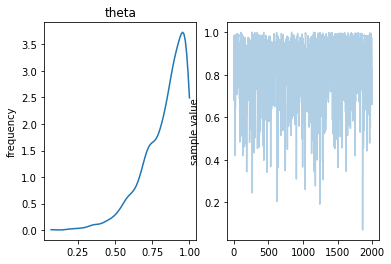

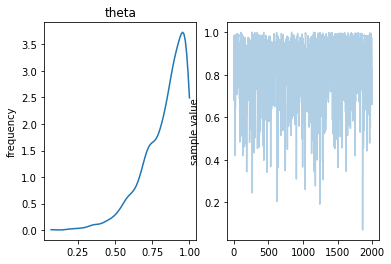

In [6]:
flip_data = {'N':4,
             'x':[1,1,1,1],
             'a':1.0,
             'b':1.0}
fit = sm.sampling(data=flip_data, iter=1000, chains=4)
fit.plot()

### Experiment three:
Use beta(4, 4) as prior, and have all trial outcomes to be head.

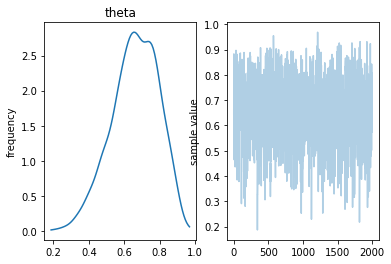

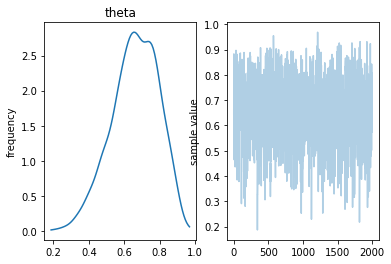

In [7]:
flip_data = {'N':4,
             'x':[1,1,1,1],
             'a':4.0,
             'b':4.0}
fit = sm.sampling(data=flip_data, iter=1000, chains=4)
fit.plot()

# Mixture of Gaussians example

In this example we use Stan to fit the parameters for a mixture of Gaussians. Take note that we have used the type `ordered` for `mu`. Try changing that to vector and compare the results.

In [9]:
MoG_model = """
data {
  int N;
  vector[N] x;
  int n_components;
}
parameters {
  ordered[n_components] mu;
  vector<lower = 0>[n_components] sigma;
  simplex[n_components] pie;
}
model {
  vector[n_components] contributions;
  // priors
  mu ~ normal(-10, 10);
  sigma ~ cauchy(0, 2);
  pie ~ dirichlet(rep_vector(2.0, n_components));
  
  
  // likelihood
  for(i in 1:N) {
    for(k in 1:n_components) {
      contributions[k] = log(pie[k]) + normal_lpdf(x[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(contributions);
  }
}
"""
sm_mog = pystan.StanModel(model_code=MoG_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f253edc8ed6587412d006ba9ec379bc NOW.
/home/aryan/.local/lib/python3.5/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpmp695kyq/stanfit4anon_model_0f253edc8ed6587412d006ba9ec379bc_2076765113422984009.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Creating a fake data set

Here we use numpy to create a fake data set using a predefined mixture of Gaussians distribution

/home/aryan/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


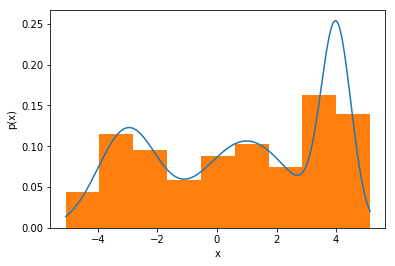

In [11]:
n = 1000
n_components = 3

params = np.array([[-3, 1],
                        [1, 1.5],
                        [4, 0.5]])
weights = np.array([0.3, 0.4, 0.3])

mixture_idx = numpy.random.choice(n_components, size=n, replace=True, p=weights)

x = numpy.fromiter((ss.norm.rvs(*(params[i])) for i in mixture_idx),
                   dtype=np.float64)

xs = np.linspace(x.min(), x.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(params, weights):
    ys += ss.norm.pdf(xs, loc=l, scale=s) * w
plt.plot(xs, ys)
plt.hist(x, normed=True, bins="fd")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.show()

### Fitting MoG model
Next we fit the Stan model to the data

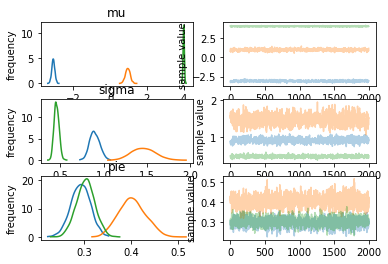

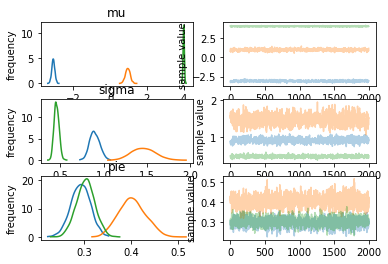

In [12]:
flip_data = {'N':n,
             'x':x,
             'n_components':n_components}
fit = sm_mog.sampling(data=flip_data, iter=500, chains=4)
fit.plot()